In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_ENDPOINT"] = os.getenv("LANGCHAIN_ENDPOINT")
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ['SERPER_API_KEY'] = os.getenv("SERPER_API_KEY")

In [5]:
from langgraph.graph import Graph

In [6]:
def function1(data:str):
    return data + " Narendra from function1"

def function2(data:str):
    return data + " Reddy from function2"

In [7]:
workflow1 =  Graph()
workflow1.add_node("function1",function1)
workflow1.add_node("function2",function2)
workflow1.add_edge("function1","function2")
workflow1.set_entry_point("function1")
workflow1.set_finish_point("function2")
app1 = workflow1.compile()

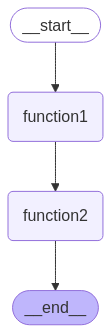

In [10]:
from IPython.display import Image,display
display(Image(app1.get_graph().draw_mermaid_png()))

In [11]:
app1.invoke("Hi")

'Hi Narendra from function1 Reddy from function2'

In [12]:
for output in app1.stream("Hi"):
    for k,v in output.items():
        print(f"{k} output is {v}")

function1 output is Hi Narendra from function1
function2 output is Hi Narendra from function1 Reddy from function2


In [22]:
def function1(data:str):
    return data + " Narendra from function1"

def function2(data:str):
    x = function3(data)
    return x + " Reddy from function2"

def function3(data:str):
    return data.upper()


In [23]:
workflow2 = Graph()
workflow2.add_node("A",function1)
workflow2.add_node("B",function2)
workflow2.add_edge("A","B")
workflow2.set_entry_point("A")
workflow2.set_finish_point("B")
app2 = workflow2.compile()

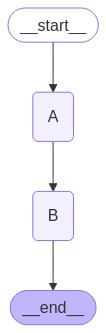

In [24]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [25]:
app2.invoke("Hi")

'HI NARENDRA FROM FUNCTION1 Reddy from function2'

In [31]:
def function1(data:str):
    return data + " Narendra from function1"

def function2(data:str):
    return data + " Reddy from function2"

def function3(data:str):
    return len(data.split())


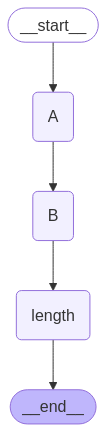

In [32]:
workflow3 = Graph()
workflow3.add_node("A",function1)
workflow3.add_node("B",function2)
workflow3.add_node("length",function3)
workflow3.add_edge("A","B")
workflow3.add_edge("B","length")
workflow3.set_entry_point("A")
workflow3.set_finish_point("length")
app3 = workflow3.compile()
display(Image(app3.get_graph().draw_mermaid_png()))

In [34]:
for node in app3.stream("Hi"):
    for func,out in node.items():
        print(f"{func} output is {out}")

A output is Hi Narendra from function1
B output is Hi Narendra from function1 Reddy from function2
length output is 7


In [35]:
app3.invoke("Hi")

7

### With RAGtool

In [41]:
from langchain_community.document_loaders import DirectoryLoader,TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

In [43]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

c:\Users\Narendra\anaconda3\envs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
loader = DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
splitter = RecursiveCharacterTextSplitter(chunk_size=100,chunk_overlap=10)
docs = loader.load()
new_docs = splitter.split_documents(docs)
vectordb = Chroma.from_documents(new_docs,embeddings,persist_directory="./chroma_db")
vectordb.persist()  # Persist to disk

C:\Users\Narendra\AppData\Local\Temp\ipykernel_18612\4200860511.py:6: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()  # Persist to disk


In [77]:
retriever = vectordb.as_retriever(search_kwargs={"k":3})

In [88]:
def function1(AgentState):
    # Make LLM Call
    messages = AgentState["messages"]
    question = messages[-1]
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    res = llm.invoke(complete_prompt)
    AgentState["messages"].append(res.content)
    return AgentState

In [89]:
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableParallel,RunnablePassthrough

In [90]:
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Gemma2-9b-It")

In [91]:
def function2(AgentState):
    messages = AgentState["messages"]
    question = messages[0]
    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = PromptTemplate.from_template(template)
    retriever_chain = RunnableParallel({"context": retriever,"question": RunnablePassthrough()}) | prompt | llm | StrOutputParser()
    return retriever_chain.invoke(question)
    

In [92]:
# Define a Langchain graph
workflow4 = Graph()
workflow4.add_node("LLM", function1)
workflow4.add_node("RAGtool", function2)
workflow4.add_edge('LLM', 'RAGtool')
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("RAGtool")
app4 = workflow4.compile()

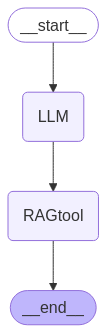

In [93]:
from IPython.display import Image, display

try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [94]:
inputs = {"messages": ["Tell me about llama3 model"]}

In [95]:
app4.invoke(inputs)

'Llama 3 is a state of the art language model, such as PaLM and Chinchilla. Meta AI\'s testing shows that the 70B version of Llama 3 is "surprisingly capable" given its size. \n'

In [96]:
for node in app4.stream(inputs):
    for func,out in node.items():
        print(f"{func} output is {out}")

LLM output is {'messages': ['Tell me about llama3 model', 'Llama 3 is an open-source large language model released by Meta AI. \n', 'True. \n']}
RAGtool output is Llama 3 is a state-of-the-art model, comparable to PaLM and Chinchilla. Meta AI has found it to be "surprisingly capable" for its size.  The weights for the first version of Llama were released to the research community. 



### Conditional Workflow

In [98]:
docs = DirectoryLoader("../data",glob="./india_economy*.txt",loader_cls=TextLoader).load()
splitter_docs = splitter.split_documents(docs)
len(splitter_docs)

42

In [99]:
splitter_docs[0]

Document(metadata={'source': '..\\data\\india_economy.txt'}, page_content='Industrial Revival and Economic Optimism for India')

In [101]:
vector = Chroma.from_documents(splitter_docs,embeddings,persist_directory="./economy_chroma_db")
vector.persist()
retriever = vector.as_retriever(search_kwargs={"k":5})

In [103]:
query = "What is India GDP in 2021?"
retriever.get_relevant_documents(query)

C:\Users\Narendra\AppData\Local\Temp\ipykernel_18612\2821110247.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents(query)


[Document(metadata={'source': '..\\data\\india_economy.txt'}, page_content='Year\tGDP\n2022\t$3,517.24B\n2021\t$3,173.04B\n2020\t$2,935.57B\n2019\t$2,869.45B\n2018\t$2,715.50B'),
 Document(metadata={'source': '..\\data\\india_economy.txt'}, page_content='India’s last eight years of GDP (hypothetical data):'),
 Document(metadata={'source': '..\\data\\india_economy.txt'}, page_content='sectors, government actions, and broader economic trends shaping India’s economy.'),
 Document(metadata={'source': '..\\data\\india_economy.txt'}, page_content='outlook for India’s economy. “We are encouraged by the steady rise in domestic consumption and'),
 Document(metadata={'source': '..\\data\\india_economy.txt'}, page_content='2017\t$2,652.10B\n2016\t$2,479.15B\n2015\t$2,390.78B')]

In [106]:
from typing import TypedDict,Annotated,Sequence
from pydantic import BaseModel, Field
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

In [105]:


class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annotate it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]



In [109]:
class TopicSelectionParser(BaseModel):
    Topic : str = Field(description="Denotes Topic")
    Reasoning : str = Field(description='Reasoning behind topic selection')

In [110]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [111]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Denotes Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [118]:
def function_1(state):
    messages = state["messages"]
    question = messages[-1]
    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    prompt = PromptTemplate(template=template,
                            input_variables=['question'],
                            partial_variables={"format_instructions":parser.get_format_instructions()})
    chain =  prompt | llm | parser
    response = chain.invoke({'question':question,"format_instructions":parser.get_format_instructions()})
    print("RESPONSE : ",response)
    return {"messages": [response.Topic]}

In [119]:
state={"messages": ["Tell me about India's Industrial Growth"]}
function_1(state)

RESPONSE :  Topic='India' Reasoning="The query directly asks for information about India's industrial growth."


{'messages': ['India']}

In [ ]:
def router(state):
    
    print('-> Router ->')
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [147]:
def rag_call(state):
    print('-> RAG Call ->')
    messages = state['messages']
    question = messages[0]  # Fetching the user question

    # Define prompt template
    template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
    prompt = PromptTemplate(template=template, input_variables=['question', 'context'])

    # Get context using retriever
    context = retriever.invoke(question)

    # Format the prompt with context and question
    formatted_prompt = prompt.format(question=question, context=context)

    # Run the LLM
    res = llm.invoke(formatted_prompt).content

    return {"messages": [res]}


In [138]:
def llm_call(state):
    
    print('-> LLM Call ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    chain =  llm | StrOutputParser()
    res = chain.invoke(question)
    return {"messages": [res]}

In [139]:
from langgraph.graph import StateGraph,END

In [143]:
workflow5 = StateGraph(AgentState) ### StateGraph with AgentState
workflow5.add_node("agent", function_1)
workflow5.add_node("RAG", rag_call)
workflow5.add_node("LLM", llm_call)
workflow5.set_entry_point("agent")
workflow5.add_conditional_edges(
    "agent",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM"
    }
)
workflow5.add_edge("RAG",END)
workflow5.add_edge("LLM",END)
app5 = workflow5.compile()


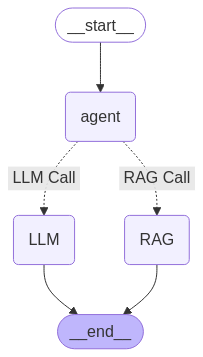

In [126]:
display(Image(app5.get_graph().draw_mermaid_png()))

In [148]:
inputs = {"messages": ["Tell me about India's Industrial Growth"]}
response = app5.invoke(inputs) 
response

RESPONSE :  Topic='India' Reasoning="The query is about India's Industrial Growth"
India
-> RAG Call ->


{'messages': ["Tell me about India's Industrial Growth",
  'India',
  AIMessage(content="India's industrial growth has outpaced expectations, raising hopes that the economy will avoid a [remainder of the sentence is cut off]. \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 211, 'total_tokens': 242, 'completion_time': 0.056363636, 'prompt_time': 0.008791558, 'queue_time': 0.23838590199999998, 'total_time': 0.065155194}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-f7d9866b-38a9-4f40-9c19-f1161f73fd4f-0', usage_metadata={'input_tokens': 211, 'output_tokens': 31, 'total_tokens': 242})]}

In [146]:
inputs = {"messages": ["who is a president of USA?"]}
output = app5.invoke(inputs)
print(output)

RESPONSE :  Topic='Not Related' Reasoning='Query is about USA president, not India.'
Not Related
-> LLM Call ->
{'messages': ['who is a president of USA?', 'Not Related', 'The current president of the United States is **Joe Biden**. \n']}
